In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px
import numpy as np

In [2]:
sns.set_theme(style="whitegrid")
sns.set_context('paper')

pd.set_option('display.max_rows', 10)

In [3]:
df1 = pd.read_csv('../data/results.csv')
df2 = pd.read_csv('../data/results_2.csv')

progs = df1['program'].unique()
print(f"Programs ({len(progs)}): {progs}")
flags = df1['flag'].unique()
print(f"Flags ({len(flags)}): {flags}")

Programs (14): ['circsim' 'hash' 'bernouilli' 'integrate' 'coins' 'queens' 'anna' 'fluid'
 'binary-trees' 'pidigits' 'callback001' 'chan' 'power' 'treejoin']
Flags (25): ['-O2' '-fno-case-merge' '-fno-case-folding' '-fno-call-arity'
 '-fno-exitification' '-fno-cmm-elim-common-blocks' '-fno-cmm-sink'
 '-fno-block-layout-cfg' '-fno-cpr-anal' '-fno-cse' '-fno-stg-cse'
 '-fno-dmd-tx-dict-sel' '-fno-do-eta-reduction'
 '-fno-do-lambda-eta-expansion' '-fno-float-in' '-fno-full-laziness'
 '-fno-ignore-asserts' '-fno-loopification' '-fno-specialise'
 '-fno-solve-constant-dicts' '-fno-stg-lift-lams' '-fno-strictness'
 '-fno-unbox-small-strict-fields' '-fno-spec-constr' '-fno-liberate-case']


In [4]:
def calculate_increase(column):
    new_dataframe = []

    for flag in flags:
        for prog in progs:
            base_mean = df1[(df1['flag'] == flag) & (df1['program'] == prog)][column].mean()
            diff_mean = df2[(df2['flag'] == flag) & (df2['program'] == prog)][column].mean()
            
            increase = ((diff_mean - base_mean) / base_mean) * 100
            
            new_dataframe.append([prog, flag, base_mean, diff_mean, increase])

    return pd.DataFrame(new_dataframe, columns=['program', 'flag', 'base_mean', 'diff_mean', 'increase'])

In [18]:
from multiprocessing import Pool
from scipy.stats import ttest_ind
from utils import random_sampling, is_normal


data_col = 'pkg_energy'

increase_df = calculate_increase(data_col)
increase_df['sig'] = [False] * len(increase_df)


task = [(prog, flag) for prog in progs for flag in flags]

def is_significant(sample):
    prog, flag = sample
    
    fst_run_df = df1[(df1['flag'] == flag) & (df1['program'] == prog)]
    snd_run_df = df2[(df2['flag'] == flag) & (df2['program'] == prog)]
    
    fst_run_data = fst_run_df[data_col].values
    snd_run_data = snd_run_df[data_col].values
    
    if is_normal(fst_run_data) and is_normal(snd_run_data) and np.var(fst_run_data) != np.var(snd_run_data):
        _, p = ttest_ind(fst_run_data, snd_run_data, equal_var=False)
    else:
        p, _, _ = random_sampling(fst_run_df, snd_run_df, data_col, reps=100000)
        
    return prog, flag, p


with Pool() as pool:
    results = pool.map(is_significant, task)

    for prog, flag, pvalue in results:
        i = increase_df.index[(increase_df['program'] == prog) & (increase_df['flag'] == flag)].values[0]
        increase_df.at[i, 'sig'] = pvalue < 0.05

increase_df[increase_df['sig'] == True]

,program,flag,base_mean,diff_mean,increase,sig
1,hash,-O2,2277740.85,2250638.15,-1.189894,True
18,coins,-fno-case-merge,14309350.65,14255059.75,-0.379409,True
19,queens,-fno-case-merge,10599380.85,10550806.05,-0.458280,True
33,queens,-fno-case-folding,10624411.30,10550345.25,-0.697131,True
34,anna,-fno-case-folding,1088843.05,1107181.10,1.684178,True
...,...,...,...,...,...,...
283,integrate,-fno-stg-lift-lams,741529.50,722947.55,-2.505895,True
296,bernouilli,-fno-strictness,818204.65,797013.55,-2.589951,True
308,circsim,-fno-unbox-small-strict-fields,1588103.15,1569814.20,-1.151622,True
322,circsim,-fno-spec-constr,1602513.65,1583366.90,-1.194795,True


In [19]:
sig_increase_df = increase_df[increase_df['sig'] == True]

display(sig_increase_df[sig_increase_df.increase == sig_increase_df.increase.max()])
display(sig_increase_df[sig_increase_df.increase == sig_increase_df.increase.min()])

,program,flag,base_mean,diff_mean,increase,sig
34,anna,-fno-case-folding,1088843.05,1107181.1,1.684178,True


,program,flag,base_mean,diff_mean,increase,sig
44,bernouilli,-fno-call-arity,750818.95,729612.45,-2.824449,True


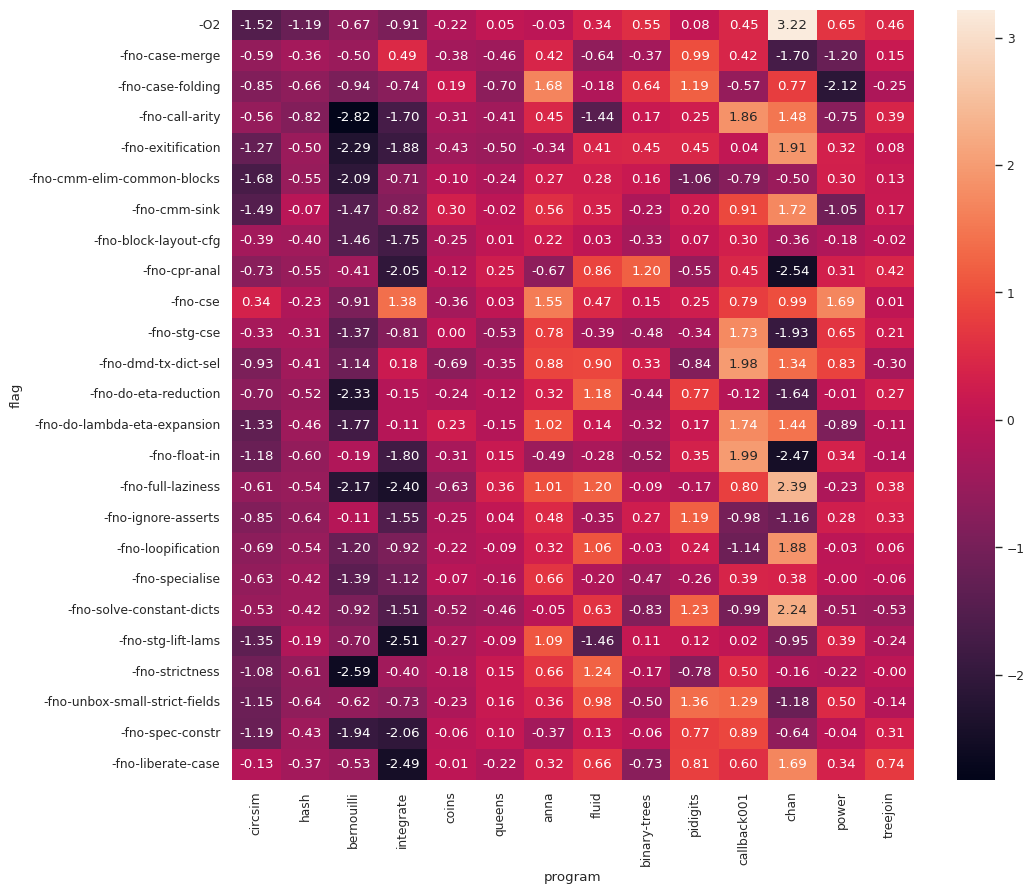

In [20]:
plt.figure(figsize=(11,10))
ax = sns.heatmap(
    data = increase_df.pivot_table(index='flag', columns='program', values='increase', sort=False),
    annot = increase_df.pivot_table(index='flag', columns='program', values='increase', sort=False),
    fmt='.2f'
)
plt.show()